# Introduction 

Data visualization is an indispensable component of data understanding and modeling regardless of dimensions. Numerical summaries cannot convey fully the information contained in a single variable or the relationship between two variables. When the number of dimensions in the data increases, visualizing the data using traditional displays becomes time consuming and even infeasible. For example, if there are two dozen quantitative variables, it is not feasible to construct scatterplots to examine the pairwise relationships of all the variables because there are hundreds of scatterplots to investigate.

A global overview can be obtained from the parallel coordinates plot if the number of features can fit in the visual display, and the number of observations are up to a few thousand. When there are even more data, it is useful to project the data on to a two-dimensional plane to obtain an understanding of their global and local structure before applying clustering or other modeling methods. 

High-dimensional visualization techniques, multidimensional scaling (MDS), and t-distributed stochastic neighbor embedding (t-SNE), have been applied successfully in machine learning and other fields to visualize and segment many types of data inlcuding images, handwritten digits, and genome sequences. 

It should be noted, however, that visualizing multidimensional data is challenging and cannot be done without making some compromises. In some respects, unsupervised learning techniques, such as MDS aand t-SNE, are more challenging than supervised learning methods such as regression, decision trees, and classification. When predicting a discrete variable using a logit model, there is a clear understanding of how to measure model fit, prediction accuracy, and the quality of the results. In contrast, in high-dimensional visualization techniques, there is no model fit or validation step because there is no response variable Y that represents the truth which to test the visualization against. Furthermore, the resulting two-dimensional arrangement of points cannot be interpreted as scatterplots, but as maps in which proximity between the points is what matters. Knowing the assumptions behind each model and how it performs the projection is imperative for proper application.

Projecting multidimensional data on a two-dimensional plane is inherently an ill-posed problem for the same reason that points on a sphere (or the earth) cannot be faithfully projected on a plane. As a result, there may not be a single high-dimensional visualization technique that can be used to reveal all the underlying information in the data. Different techniques reveal different aspects of the data. In particular, linear projection methods, such as  MDS, can uncover the global structure of the data and the presence of outliers. Nonlinear methods, such as the t-SNE, are better at uncovering clusters at different scales, but are harder to interpret because points that are equidistant in the projection may not be equidistant in the multidimensional space.


Here we present two high dimensinal projection algorithms 

1. MDS is one of the most widely researched dimensionality reduction techniques with a large number of variations that can make it a linear or a nonlinear projection. This is notebook we use MDS as a linear projection. 

2. t-SNE is one of the most potent nonlinear high-dimensional visualization techniques for algorithms that do not project the high-dimensional distances between points proportionally. It was introduced in 2008 and has found a large number of applications especially in medicine, biology, and machine learning.


We start with some imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, MDS
from scipy.spatial.distance import pdist

import matplotlib as mpl 
 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/worldcities.csv")

In [3]:
df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [4]:
df = (df.dropna()
        .sort_values(['country', "population"], ascending=[True, False])
) 

Let's select a number of European countries to project on the plane. From each country we select the most five most populus cities. 

In [5]:
european_countries = ['Greece', 'Italy', "Spain", "France", 
                   'United Kingdom', "Austria", "Poland", "Norway", "Sweden", "Romania"]

In [6]:
eu_cities = df[df.country.isin(european_countries)].groupby(['country']).head(5)

In [7]:
eu_cities.head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4227,Vienna,Vienna,48.2000,16.3666,Austria,AT,AUT,Wien,primary,2400000.0,1040261752
4222,Linz,Linz,48.3192,14.2888,Austria,AT,AUT,Oberösterreich,admin,349161.0,1040261171
4225,Graz,Graz,47.0778,15.4100,Austria,AT,AUT,Steiermark,admin,263234.0,1040184559
4221,Salzburg,Salzburg,47.8105,13.0400,Austria,AT,AUT,Salzburg,admin,206279.0,1040312147
4219,Innsbruck,Innsbruck,47.2804,11.4100,Austria,AT,AUT,Tirol,admin,155214.0,1040038924
6686,Paris,Paris,48.8667,2.3333,France,FR,FRA,Île-de-France,primary,9904000.0,1250015082
6695,Lyon,Lyon,45.7700,4.8300,France,FR,FRA,Auvergne-Rhône-Alpes,admin,1423000.0,1250196189
6682,Marseille,Marseille,43.2900,5.3750,France,FR,FRA,Provence-Alpes-Côte d’Azur,admin,1400000.0,1250774071
6694,Lille,Lille,50.6500,3.0800,France,FR,FRA,Hauts-de-France,admin,1044000.0,1250071961
6731,Nice,Nice,43.7150,7.2650,France,FR,FRA,Provence-Alpes-Côte d’Azur,minor,927000.0,1250774553


The similarity between cities can depent on multiple variables, such as area, population, length of roadway network, income etc. In this example, similarity will be the distance bewtween two cities on the surface of the earth. Other distance metrics such as the roadway distance can also be used. 

 we will rely on latitude and longitude to compute the distance between a pair of cities. We will consider the distance metric as the similarity metric. 

 The latitude and logitude values themselves are not fundamental to the relatophips cities have. They could be recoded using different units or in a different coordinate system. What is important, and what algorithms depend on, is the distance between each point and every other point in the dataTo to compute the pairwise distances between all the cities. 
 
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our cities dataset

In [8]:
eu_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4227,Vienna,Vienna,48.2000,16.3666,Austria,AT,AUT,Wien,primary,2400000.0,1040261752
4222,Linz,Linz,48.3192,14.2888,Austria,AT,AUT,Oberösterreich,admin,349161.0,1040261171
4225,Graz,Graz,47.0778,15.4100,Austria,AT,AUT,Steiermark,admin,263234.0,1040184559
4221,Salzburg,Salzburg,47.8105,13.0400,Austria,AT,AUT,Salzburg,admin,206279.0,1040312147
4219,Innsbruck,Innsbruck,47.2804,11.4100,Austria,AT,AUT,Tirol,admin,155214.0,1040038924


In [9]:
from math import radians

In [10]:
eu_cities['latr'] = eu_cities['lat'].apply(radians)
eu_cities['lngr'] = eu_cities['lng'].apply(radians)

In [11]:
from sklearn.metrics import pairwise_distances
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
D = pairwise_distances(eu_cities[['latr', 'lngr']], metric="haversine") * 6371000/1000  # multiply by Earth radius to get kilometers
D.shape

(50, 50)

For our *N*=50 cities, we obtain a 50x50 matrix. 

Text(0.5, 1.0, 'Distance Matrix for the 50 Selected European Cities')

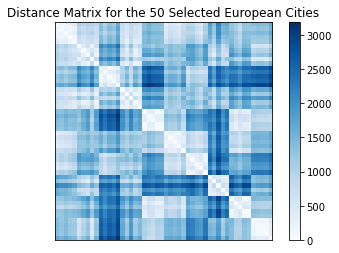

In [12]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='None')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Distance Matrix for the 50 Selected European Cities")

If we were to put the distance matrix into a dataframe it would look like this: 

In [13]:
eu_cities_distances = pd.DataFrame(D, index=eu_cities.city, columns=eu_cities.city)

In [14]:
eu_cities_distances.head()

city,Vienna,Linz,Graz,Salzburg,Innsbruck,Paris,Lyon,Marseille,Lille,Nice,...,Stockholm,Göteborg,Malmö,Västerås,Örebro,Birmingham,Manchester,Leeds,Sheffield,Glasgow
city,,,,,,,,,,,,,,,,,,,,,
Vienna,0.000000,154.382167,143.898492,251.226899,384.411714,1034.470986,914.850500,1011.216821,997.279369,861.463745,...,1245.008380,1100.849666,852.001225,1271.007625,1234.331205,1377.554658,1428.047406,1397.566436,1376.315829,1638.923950
Linz,154.382167,0.000000,161.534782,108.677224,244.062413,880.456941,770.073939,887.900843,849.185929,745.258882,...,1251.338247,1059.607326,812.264835,1266.104551,1220.321013,1234.996995,1290.555033,1262.764364,1238.917545,1512.316248
Graz,143.898492,161.534782,0.000000,195.956354,303.125279,992.269757,823.206859,891.203720,983.961266,737.195320,...,1376.090873,1208.628869,959.925784,1397.702507,1356.913746,1376.911247,1437.912333,1412.522607,1386.494826,1666.970410
Salzburg,251.226899,108.677224,195.956354,0.000000,135.798577,799.355684,664.547066,779.660937,788.317871,638.462871,...,1324.996526,1107.398836,864.296048,1333.823596,1283.314401,1182.545863,1245.982600,1222.294053,1194.764389,1481.465988
Innsbruck,384.411714,244.062413,303.125279,135.798577,0.000000,696.588637,530.488350,647.557450,713.635109,511.258432,...,1412.061864,1164.839134,930.004902,1413.555729,1357.598668,1113.702160,1186.708557,1168.511020,1136.516543,1437.775970


Let's create a dataframe that will contain all the 2D maps. The dataframe will have as many rows as the number of cities. Its columns will contain the position of the points on the 2D maps from the different algorithms. 

In [15]:
eu_results = pd.DataFrame(data=eu_cities.city, columns=['city'])

Let's run the MDS algoritm first. It's output is a pair of coordiates $(x,y)$ for each data point or city 

In [16]:

mds_results =  MDS(verbose=1, dissimilarity='precomputed').fit_transform(eu_cities_distances.values)

eu_results['mds_x'] = mds_results[:,0]
eu_results['mds_y'] = mds_results[:,1]

breaking at iteration 57 with stress 4025.9976527231393
breaking at iteration 51 with stress 3990.716133109114
breaking at iteration 106 with stress 4025.644472925149
breaking at iteration 59 with stress 4027.768776233082


Text(0.5, 1.0, 'MDS projection of EU cities. (Linear Projection)')

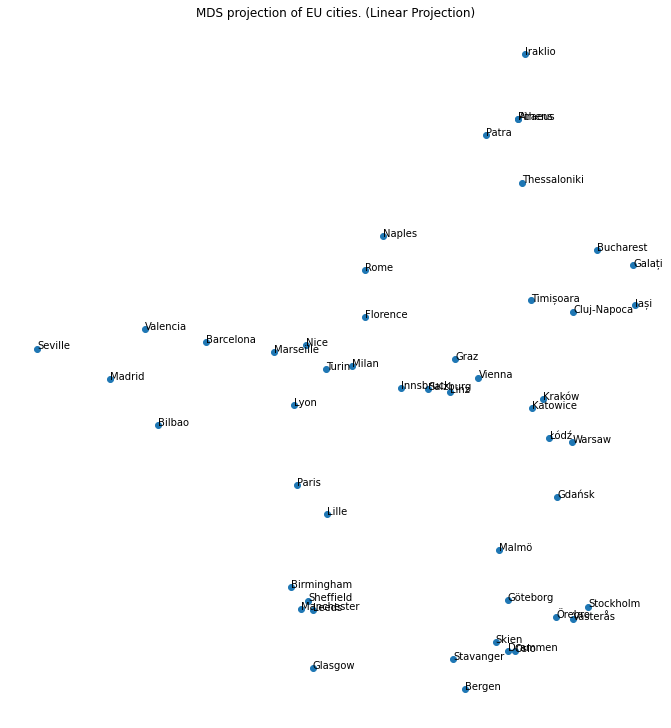

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_aspect("equal")  
ax.scatter(eu_results['mds_x'], eu_results['mds_y'])
ax.set_facecolor("white")
ax.axis('off')

for city, x,y in zip(eu_results.city, eu_results.mds_x, eu_results.mds_y):
    ax.annotate(city, (x, y))

fig.tight_layout()
ax.set_title("MDS projection of EU cities. (Linear Projection)")

Visualizing the data using plotly can be useful if we want to interactivlty zoom and select points on the map.

In [18]:
import plotly.express as px
import plotly.graph_objects as go

In [19]:
fig = px.scatter(eu_results, x="mds_x", y="mds_y",
                text="city", width=800, height=800, title="MDS Projection of European Cities (Linear Projection)")


fig.update_xaxes(
    showticklabels=False
)
fig.update_yaxes(
    showticklabels=False
)

fig

Things to note

1. The map gives us an understanding of the distrbution of the data/points. 
2. **Data points that are closer together on the map are closer together on the surface of the earth (or the HD space)**. MDS is a liner projection. 
3. The **relative position** of the point matters and not the absolute. If we re-run the projection the map may be oriented differently, may be the mirror image of what we have now or it may be rotated left or right. 

4. MDS places higher value in reflecting the disimilarity of faraway points. It is not very good at showing local structure (and clusters)


To see how succesful the MDS projection has been in projecting distances on the surface of the earth on the 2D map we can create the follwoing scatterplot. Each point in the scatterplot is a pair of cities. On the X axis is the distance on the surface of the earth. On the Y axis is the distance on the 2D map. A succesful MDS projection will place cities on the 2D map in a way that the distance on the map is proportional to the distance on the surface of the earth. 

In [20]:
from scipy.spatial.distance import pdist, squareform

In [21]:
map_distances_eu = pdist(eu_results[['mds_x', 'mds_y']].values)
HD_distances_eu = squareform(eu_cities_distances.values)

Text(0.5, 1.0, 'Shepard Diagram for MDS')

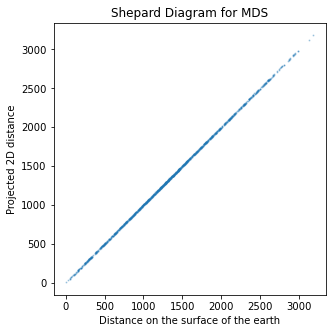

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(HD_distances_eu, map_distances_eu, s=1, alpha=0.3)

ax.set_aspect("equal")
ax.set_xlabel("Distance on the surface of the earth")
ax.set_ylabel("Projected 2D distance")
#ax.plot([0,3000], [0, 3000], color='grey', ls="--")
ax.set_title("Shepard Diagram for MDS")

Let's try now to visualize cities from different continents. This is a harder problem of course because it is well known that the surface of a sphere cannot be projected on a plane faithfuly. This is also the reason why there are so many geodetic projections. Some maintain area, others angle between lines, etc. 

In [23]:
world_countries = ['Australia', 'United Kingdom', "Greece", "Italy", "France", "Germany", "Spain",  
                     'South Africa', "India", "China", "Brazil", 'United States']

In [24]:
world_cities = df[df.country.isin(world_countries)].groupby(['country']).head(5)

In [25]:
df[df.country.isin(['United States'])].sort_values("population", ascending=False).head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
8250,Washington,Washington,38.9047,-77.0163,United States,US,USA,District of Columbia,primary,5191844.0,1840006060
11083,Atlanta,Atlanta,33.7627,-84.4231,United States,US,USA,Georgia,admin,5080712.0,1840013660
11680,Boston,Boston,42.3189,-71.0838,United States,US,USA,Massachusetts,admin,4556916.0,1840000455
11506,Phoenix,Phoenix,33.5722,-112.0891,United States,US,USA,Arizona,admin,4054083.0,1840020568
10479,Denver,Denver,39.7621,-104.8759,United States,US,USA,Colorado,admin,2741534.0,1840018789


In [26]:
world_cities.head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4245,Sydney,Sydney,-33.9200,151.1852,Australia,AU,AUS,New South Wales,admin,4630000.0,1036074917
4381,Melbourne,Melbourne,-37.8200,144.9750,Australia,AU,AUS,Victoria,admin,4170000.0,1036533631
4420,Brisbane,Brisbane,-27.4550,153.0351,Australia,AU,AUS,Queensland,admin,1860000.0,1036192929
4299,Perth,Perth,-31.9550,115.8400,Australia,AU,AUS,Western Australia,admin,1532000.0,1036178956
4293,Adelaide,Adelaide,-34.9350,138.6000,Australia,AU,AUS,South Australia,admin,1145000.0,1036538171
5096,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519
5044,Rio de Janeiro,Rio de Janeiro,-22.9250,-43.2250,Brazil,BR,BRA,Rio de Janeiro,admin,11748000.0,1076887657
4915,Belo Horizonte,Belo Horizonte,-19.9150,-43.9150,Brazil,BR,BRA,Minas Gerais,admin,5575000.0,1076967355
4821,Porto Alegre,Porto Alegre,-30.0500,-51.2000,Brazil,BR,BRA,Rio Grande do Sul,admin,3917000.0,1076658221
4778,Brasília,Brasilia,-15.7833,-47.9161,Brazil,BR,BRA,Distrito Federal,primary,3716996.0,1076144436


In [27]:
world_cities['latr'] = world_cities['lat'].apply(radians)
world_cities['lngr'] = world_cities['lng'].apply(radians)

In [28]:
D = pairwise_distances(world_cities[['latr', 'lngr']], metric="haversine") * 6371000/1000  # multiply by Earth radius to get kilometers
D.shape

(60, 60)

Text(0.5, 1.0, 'Distance Matrix for the 60 Selected World Cities')

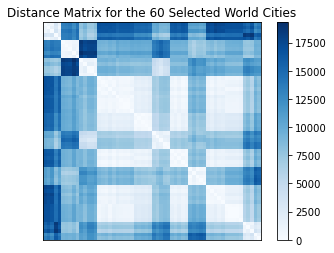

In [29]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='None')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("Distance Matrix for the 60 Selected World Cities")

In [30]:
world_cities_distances = pd.DataFrame(D, index=world_cities.city, columns=world_cities.city).round(0)

In [31]:
world_cities_distances.head()

city,Sydney,Melbourne,Brisbane,Perth,Adelaide,São Paulo,Rio de Janeiro,Belo Horizonte,Porto Alegre,Brasília,...,Birmingham,Manchester,Leeds,Sheffield,Glasgow,Washington,Atlanta,Boston,Phoenix,Denver
city,,,,,,,,,,,,,,,,,,,,,
Sydney,0.0,708.0,740.0,3290.0,1159.0,13352.0,13513.0,13819.0,12523.0,14129.0,...,17046.0,17000.0,16942.0,16967.0,16934.0,15716.0,14946.0,16243.0,12557.0,13421.0
Melbourne,708.0,0.0,1376.0,2724.0,654.0,13083.0,13206.0,13528.0,12283.0,13904.0,...,16990.0,16971.0,16916.0,16930.0,16976.0,16385.0,15588.0,16930.0,13244.0,14118.0
Brisbane,740.0,1376.0,0.0,3609.0,1603.0,13963.0,14147.0,14441.0,13121.0,14703.0,...,16546.0,16481.0,16424.0,16457.0,16372.0,15249.0,14541.0,15722.0,12068.0,12894.0
Perth,3290.0,2724.0,3609.0,0.0,2133.0,13567.0,13519.0,13857.0,12986.0,14432.0,...,14604.0,14626.0,14582.0,14576.0,14744.0,18619.0,18115.0,18711.0,15570.0,16278.0
Adelaide,1159.0,654.0,1603.0,2133.0,0.0,13488.0,13578.0,13910.0,12716.0,14334.0,...,16356.0,16343.0,16290.0,16301.0,16369.0,16839.0,16094.0,17325.0,13661.0,14496.0


In [32]:
world_results = pd.DataFrame(data=world_cities.city, columns=['city'])

In [33]:

mds_results =  MDS(verbose=1, dissimilarity='precomputed').fit_transform(world_cities_distances.values)

world_results['mds_x'] = mds_results[:,0]
world_results['mds_y'] = mds_results[:,1]

breaking at iteration 65 with stress 2134296579.945724
breaking at iteration 154 with stress 2134068409.553594
breaking at iteration 86 with stress 2135597070.8634744
breaking at iteration 237 with stress 2134068409.5367002


In [34]:
fig = px.scatter(world_results, x="mds_x", y="mds_y",
                text="city", 
                width=800, height=800, 
                title="MDS Projection of World Cities (Linear Projection)")


fig.update_xaxes(
    showticklabels=False
)
fig.update_yaxes(
    showticklabels=False
)

fig

Points to make: 

1. The size of a cluster on the 2D map is proportional to the size of the cluster(country or continent) on the surface of the earth
2. The relative position of the clusters on the map is the same as the relative positions of the clusters in the high dimensional data 
3. MDS tries its best to represent faithfully distances from far away points.  
4. MDS is not that good in representing the **local** structure of the data (=which city is closer to which)


In [35]:
map_distances_world = pdist(world_results[['mds_x', 'mds_y']].values)
HD_distances_world = squareform(world_cities_distances.values)

The Shepard diagram reveals a lot more deviations from the ideal diagonal line. So for some city pairs the distance on the map is not proportional to the distance on the surface of the earth and the difference can be significant. For the vast majority of the city pairs though, the MDS projection does a good job. 

Text(0.5, 1.0, 'Shepard Diagram for MDS')

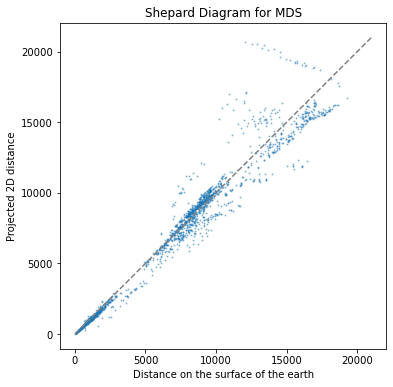

In [36]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(HD_distances_world, map_distances_world, s=1, alpha=0.4)

ax.set_aspect("equal")
ax.set_xlabel("Distance on the surface of the earth")
ax.set_ylabel("Projected 2D distance")
ax.plot([0,21000], [0, 21000], color='grey', ls="--")
ax.set_title("Shepard Diagram for MDS")

## Non-Linear projection (t-SNE)

The non-linear projections are harder to interpret compared to MDS or PCA. This because distances on the 2D map are no longer proportional to distances on the surface of the earth. In other workds, t-SNE distorts space. It expands high density areas in and condenses low density ones to show local structure(=clusters) at different scales. For the non-linear projections, cluster membership and representing local neibhorhood relations is more important than showing the global structure of the data correctly. 

In [37]:
tsne_results = TSNE(n_components=2, verbose=1, perplexity=30,
                metric="precomputed").fit_transform(world_cities_distances.values)

world_results['tsne30_x'] = tsne_results[:,0]
world_results['tsne30_y'] = tsne_results[:,1]

[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 47.833030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.911415
[t-SNE] KL divergence after 1000 iterations: 0.227968


In [38]:
fig = px.scatter(world_results, x="tsne30_x", y="tsne30_y",
                text="city", 
                width=800, height=800, 
                title="TNSE Projection of World Cities. Perplexity 30. (Non-Linear Projection)")


fig.update_xaxes(
    showticklabels=False
)
fig.update_yaxes(
    showticklabels=False
)

fig

TSNE is less intuitive than MDS and harde to interpet if you don't know how it works. Things to note: 
 
1. Dense areas are expanded and sparse areas are condensed
2. Cluster size does not reflect cluster size in the data
3. Relative position of clusters may be off

t-SNE is sensitive to the perplexity parameter whose range is recomended to be between 5 and 50. Lower perplexity values will emphasize local structure structures at different scales (clusters within clusters). Let's try perplexity = 10 

In [41]:
tsne_results = TSNE(n_components=2,  verbose=0, perplexity=10,
                metric="precomputed").fit_transform(world_cities_distances.values)

world_results['tsne10_x'] = tsne_results[:,0]
world_results['tsne10_y'] = tsne_results[:,1]

In [42]:
fig = px.scatter(world_results, x="tsne10_x", y="tsne10_y",
                text="city", 
                width=800, height=800, 
                title="TNSE Projection of World Cities. Perplexity 10. (Non-Linear Projection)")


fig.update_xaxes(
    showticklabels=False
)
fig.update_yaxes(
    showticklabels=False
)

fig

## Suggestions 

High-dimensional visualization techniques should be part of data exploration to understand the properties of the dataset and answer whether there are any clusters or groupings in the underlying data or whether there are any outliers. It should be stressed that the produced maps cannot be judged independently of the dimensionality reduction method used. Unlike histograms and scatterplots that can communicate information to a more general audience, the techniques described in this presentation are part of an analyst’s toolbox to uncover information, and using them as communication tools can confuse those who are not familiar.

We believe that the following steps need to be applied when conducting data reduction techniques to identify patterns in high-dimensional data: 

1. Find the inherent dimensionality of the dataset by applying PCA and quantifying the proportion of variance explained by each principal component.

2. Apply both a linear and a nonlinear method.

2. When applying MDS, check the quality of the projection based on the value of the stress function (MDS) or by using a Shepard diagram.

3. Use the linear projection to investigate the global structure and identify any outliers.

4. Use the nonlinear projection to investigate local structure and clusters.

5. When using MDS or t-SNE, apply the same algorithm multiple times to ensure stability.

6. When using t-SNE, perform sensitivity analysis to understand how maps change based on algorithm parameters such as perplexity.

7. Interactively select points of the map projection and, based on the points to which they correspond in the multidimensional space, understand how the points are arranged on the map. 



Things to note
1. Europe has been expanded. The size of the European countries on the map do not reflect reality. However, it is easier to find local strucure and identify which cities belong to which country. 
2. The relative position of the cluster/continents does not reflect the position of the continents on earth. Also the distance beween the clusters on the map does is not proportional to the distance between the continents on earth. 